In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
# get_ipython().magic(u'matplotlib auto')
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# import torch
from tensorflow import keras
import statistics

In [2]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Activation
from tensorflow import reshape
from keras.utils import np_utils
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D,AveragePooling1D
from tensorflow.keras.layers import Input, LocallyConnected1D
from tensorflow.keras.layers import SeparableConv1D, Bidirectional
from tensorflow.keras.layers import LocallyConnected2D
from tensorflow.keras.layers import ZeroPadding2D,ZeroPadding1D, MaxPooling2D, Bidirectional
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import CSVLogger,LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [3]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
from numpy import std
# import coremltools
# from torch import nn, optim
# import torch.nn.functional as F
import scipy.io
from scipy import stats
#from IPython.display import display, HTML
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU,SimpleRNN
from tensorflow.keras.layers import TimeDistributed
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

In [4]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(20, 14))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [5]:
# The number of steps within one time segment
TIME_PERIODS = 500
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 500
N_FEATURES = 10

In [6]:
column_names = ['C'+str(j) for j in range(1, N_FEATURES+1)]
lst = ['Class_label']
column_names = column_names+lst
print(column_names)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'Class_label']


In [7]:
def read_data_Train(file_path_Train):
    df_Train = pd.read_csv(file_path_Train,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Train['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Train['Class_label'] = df_Train['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Train.dropna(axis=0, how='any', inplace=True)
    return df_Train
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [8]:
def show_basic_dataframe_info(dataframe):
    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [9]:
def read_data_Test(file_path_Test):
    df_Test = pd.read_csv(file_path_Test,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Test['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Test['Class_label'] = df_Test['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Test.dropna(axis=0, how='any', inplace=True)
    return df_Test

In [10]:
 pd.options.display.float_format = "{:,.5f}".format

In [11]:
# 15 function to segment data into trial lengths (trial length =513 samples in this dataset)
def create_segments_and_labels(df, time_steps,step,n_features, label_name):
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
      for j in range(1, n_features+1):
        L = ('C'+str(j)) 
        segments.append(df[str(L)].values[i: i + time_steps])
      label = stats.mode(df[label_name][i: i + time_steps])[0][0]
      labels.append(label)
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, n_features)
    labels = np.asarray(labels)
    return reshaped_segments, labels

In [12]:
# import os
path='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/Total_process_TT/'

In [13]:
# file_path_train=path+'Train_data'+'.'+'csv'
file_path_train=path+'nina_pro_naveen_DB1_Train'+'.'+'csv'
print(file_path_train)

/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/Total_process_TT/nina_pro_naveen_DB1_Train.csv


In [14]:
file_path_test=path+'nina_pro_naveen_DB1_Test'+'.'+'csv'
# file_path_test=path+'Test_data'+'.'+'csv'
print(file_path_test)

/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/Total_process_TT/nina_pro_naveen_DB1_Test.csv


In [15]:
df_Train=read_data_Train(file_path_train)
show_basic_dataframe_info(df_Train)
df_Train.head(5)

Number of columns in the dataframe: 11
Number of rows in the dataframe: 4914000



,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label
0,0.00720,0.00242,0.00493,0.00242,0.00245,0.00241,0.00308,0.01634,0.00241,0.00247,1.00000
1,0.00836,0.00243,0.00478,0.00242,0.00245,0.00241,0.00312,0.01699,0.00241,0.00247,1.00000
2,0.00949,0.00243,0.00464,0.00242,0.00246,0.00241,0.00317,0.01762,0.00241,0.00248,1.00000
3,0.01052,0.00243,0.00451,0.00242,0.00246,0.00241,0.00322,0.01822,0.00242,0.00248,1.00000
4,0.01142,0.00243,0.00439,0.00242,0.00246,0.00241,0.00327,0.01877,0.00242,0.00248,1.00000


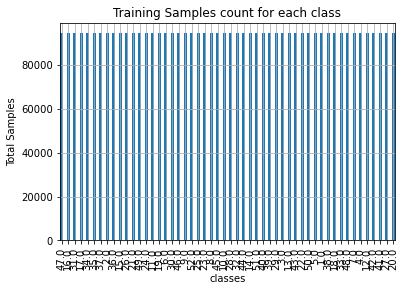

In [16]:
df_Train['Class_label'].value_counts().plot(kind='bar',
                                   title='Training Samples count for each class')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('Total Samples')
plt.xlabel('classes')
plt.grid(True)
plt.autoscale(axis='x',tight=True)

In [17]:
df_Test=read_data_Test(file_path_test)
show_basic_dataframe_info(df_Test)
df_Test.head(5)

Number of columns in the dataframe: 11
Number of rows in the dataframe: 2106000



,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label
0,0.03176,0.00247,0.00243,0.00240,0.00244,0.00240,0.00257,0.03562,0.00244,0.00241,1.00000
1,0.03205,0.00248,0.00244,0.00240,0.00245,0.00240,0.00258,0.03567,0.00244,0.00241,1.00000
2,0.03234,0.00248,0.00245,0.00240,0.00246,0.00240,0.00259,0.03569,0.00244,0.00241,1.00000
3,0.03261,0.00249,0.00246,0.00240,0.00246,0.00240,0.00260,0.03570,0.00244,0.00241,1.00000
4,0.03285,0.00249,0.00246,0.00240,0.00246,0.00240,0.00261,0.03566,0.00245,0.00241,1.00000


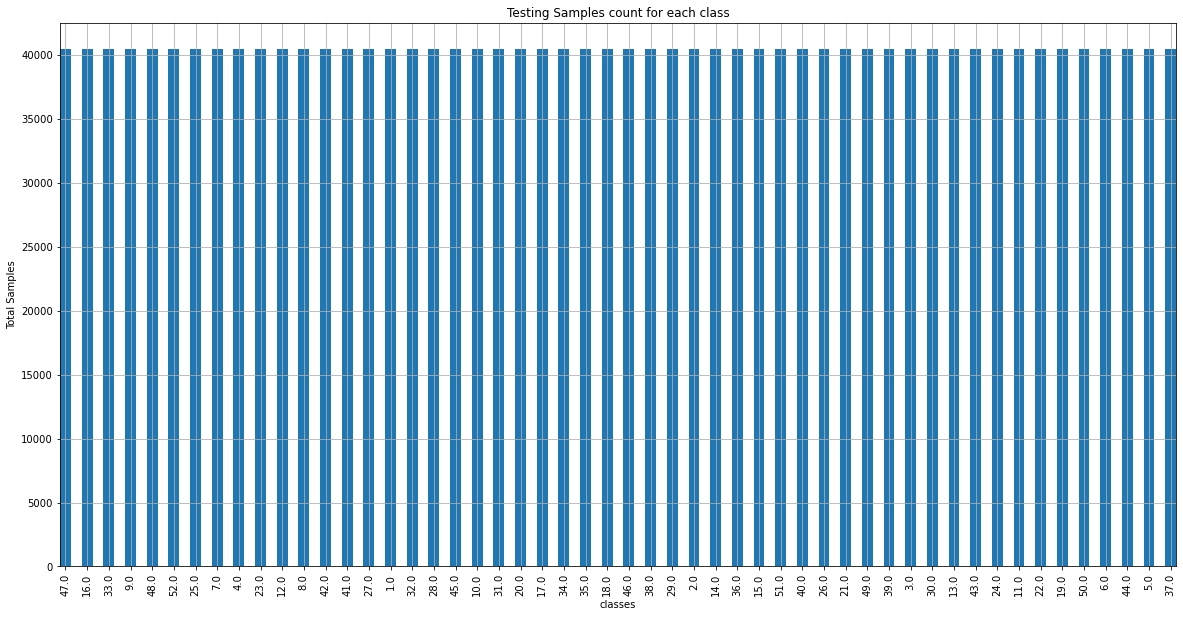

In [18]:
df_Test['Class_label'].value_counts().plot(kind='bar',
                                   title='Testing Samples count for each class')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('Total Samples')
plt.xlabel('classes')
plt.grid(True)
plt.autoscale(axis='x',tight=True)

In [19]:
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df_Train[LABEL] = le.fit_transform(df_Train['Class_label'].values.ravel())
# df_Valid[LABEL] = le.fit_transform(df_Valid['Class_label'].values.ravel())
df_Test[LABEL] = le.fit_transform(df_Test['Class_label'].values.ravel())

In [20]:
pd.options.display.float_format = "{:,.5f}".format
df_Train.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,0.00720,0.00242,0.00493,0.00242,0.00245,0.00241,0.00308,0.01634,0.00241,0.00247,1.00000,0
1,0.00836,0.00243,0.00478,0.00242,0.00245,0.00241,0.00312,0.01699,0.00241,0.00247,1.00000,0
2,0.00949,0.00243,0.00464,0.00242,0.00246,0.00241,0.00317,0.01762,0.00241,0.00248,1.00000,0
3,0.01052,0.00243,0.00451,0.00242,0.00246,0.00241,0.00322,0.01822,0.00242,0.00248,1.00000,0
4,0.01142,0.00243,0.00439,0.00242,0.00246,0.00241,0.00327,0.01877,0.00242,0.00248,1.00000,0


In [21]:
scaler = preprocessing.StandardScaler().fit(df_Train.iloc[:,0:N_FEATURES])

In [22]:
df_Train.iloc[:,0:N_FEATURES]=scaler.transform(df_Train.iloc[:,0:N_FEATURES])

In [23]:
pd.options.display.float_format = "{:,.5f}".format
df_Train.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,-0.67597,-0.64137,-0.51809,-0.43726,-0.37267,-0.45614,-0.76033,-0.90886,-0.51943,-0.77849,1.00000,0
1,-0.67360,-0.64137,-0.51846,-0.43725,-0.37263,-0.45613,-0.76027,-0.90759,-0.51942,-0.77848,1.00000,0
2,-0.67130,-0.64136,-0.51882,-0.43725,-0.37260,-0.45613,-0.76019,-0.90634,-0.51942,-0.77847,1.00000,0
3,-0.66919,-0.64136,-0.51915,-0.43724,-0.37256,-0.45613,-0.76012,-0.90516,-0.51942,-0.77846,1.00000,0
4,-0.66736,-0.64135,-0.51946,-0.43724,-0.37252,-0.45612,-0.76004,-0.90409,-0.51942,-0.77845,1.00000,0


In [24]:
pd.options.display.float_format = "{:,.5f}".format
df_Test.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,0.03176,0.00247,0.00243,0.00240,0.00244,0.00240,0.00257,0.03562,0.00244,0.00241,1.00000,0
1,0.03205,0.00248,0.00244,0.00240,0.00245,0.00240,0.00258,0.03567,0.00244,0.00241,1.00000,0
2,0.03234,0.00248,0.00245,0.00240,0.00246,0.00240,0.00259,0.03569,0.00244,0.00241,1.00000,0
3,0.03261,0.00249,0.00246,0.00240,0.00246,0.00240,0.00260,0.03570,0.00244,0.00241,1.00000,0
4,0.03285,0.00249,0.00246,0.00240,0.00246,0.00240,0.00261,0.03566,0.00245,0.00241,1.00000,0


In [25]:
df_Test.iloc[:,0:N_FEATURES]=scaler.transform(df_Test.iloc[:,0:N_FEATURES])

In [26]:
pd.options.display.float_format = "{:,.5f}".format
df_Test.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,-0.62585,-0.64122,-0.52438,-0.43732,-0.37277,-0.45618,-0.76115,-0.87110,-0.51936,-0.77862,1.00000,0
1,-0.62526,-0.64121,-0.52435,-0.43732,-0.37266,-0.45618,-0.76114,-0.87102,-0.51936,-0.77862,1.00000,0
2,-0.62467,-0.64120,-0.52433,-0.43731,-0.37256,-0.45618,-0.76112,-0.87096,-0.51935,-0.77862,1.00000,0
3,-0.62412,-0.64119,-0.52432,-0.43731,-0.37252,-0.45618,-0.76110,-0.87095,-0.51935,-0.77862,1.00000,0
4,-0.62363,-0.64117,-0.52432,-0.43731,-0.37250,-0.45618,-0.76109,-0.87102,-0.51934,-0.77862,1.00000,0


In [27]:
x_train, y_train = create_segments_and_labels(df_Train,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
print('x_train shape: ', x_train.shape)
# print(x_train)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
print('num_time_periods',num_time_periods)
print('num_sensors',num_sensors)
num_classes = le.classes_.size
print('class_list',list(le.classes_))
# input_shape = (num_time_periods,num_sensors)
# print(input_shape)
input_shape = (num_time_periods,num_sensors)
#x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train[0].shape)
print('input_shape:', input_shape)
x_train = x_train.astype('float32')
# x_train = [torch.tensor(arr, dtype=torch.float32) for arr in x_train]
# y_train = y_train.astype('float32')
# print(y_train)
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print(y_train_hot)
# y_train_hot= [torch.tensor(arr, dtype=torch.uint8) for arr in y_train_hot]
print('New y_train shape: ', y_train_hot.shape)

x_train shape:  (9827, 500, 10)
9827 training samples
y_train shape:  (9827,)
num_time_periods 500
num_sensors 10
class_list [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0]
x_train shape: (500, 10)
input_shape: (500, 10)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
New y_train shape:  (9827, 52)


In [28]:
x_test, y_test = create_segments_and_labels(df_Test,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
print('x_test shape: ', x_test.shape)
# print(x_train)
print(x_test.shape[0], 'testing samples')
print('y_test shape: ', y_test.shape)
# Set input_shape / reshape for Keras
#x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test_hot = np_utils.to_categorical(y_test, num_classes)

x_test shape:  (4211, 500, 10)
4211 testing samples
y_test shape:  (4211,)


In [29]:
# n_steps, n_length = 20, 25
# n_steps, n_length= 10, 50
# n_steps, n_length= 16, 32
n_steps, n_length = 25, 20
n_depth=10
x_train = x_train.reshape(x_train.shape[0], n_steps, n_length,n_depth)
print('x_train shape: ', x_train.shape)
# x_valid = x_valid.reshape(x_valid.shape[0], n_steps, n_length, n_depth)
# print('x_valid shape: ', x_valid.shape)
x_test = x_test.reshape(x_test.shape[0], n_steps, n_length,n_depth)
print('x_test shape: ', x_test.shape)
n_outputs = y_train_hot.shape[1]
print('n_outputs',n_outputs)

x_train shape:  (9827, 25, 20, 10)
x_test shape:  (4211, 25, 20, 10)
n_outputs 52


In [30]:
LABELS=[]
for i in range(1,n_outputs+1,1):
  LABELS.append (i)
print(LABELS)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]


In [31]:
def step_decay(epoch):
  initial_lrate = 1e-4
  drop = 0.1
  epochs_drop = 70.0
  lrate = initial_lrate * tf.math.pow(drop,  
          tf.math.floor((1+epoch)/epochs_drop))
  return lrate

In [32]:
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [38]:
verbose, epochs, batch_size = 0, 200, 32

In [39]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=9, padding='same', kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04)), \
                           input_shape=(n_steps,n_length,n_depth)))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(MaxPooling1D(pool_size=8,strides=2)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=5,padding="same",kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04))))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Dropout(0.2093)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=5,padding="same",kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04))))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Dropout(0.2093)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3,padding="same",kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04))))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Dropout(0.2093)))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(Flatten()))
# model.add(Flatten())
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(SimpleRNN(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(SimpleRNN(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(BatchNormalization(epsilon=1e-05, momentum=0.9, weights=None))
# model.add(Bidirectional(SimpleRNN(200)))
# model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='tanh'))
# model.add(Dense(200, activation='tanh'))
model.add(BatchNormalization(epsilon=1e-05, momentum=0.9, weights=None))
model.add(Dense(n_outputs, activation='softmax'))

In [40]:
adam=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
checkpoint_filepath = '/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/checkpoint.hdf5'
# model.load_weights(checkpoint_filepath) 
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,verbose=1, monitor='val_accuracy',save_weights_only=True,save_best_only=True)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, 25, 10, 64)        5824      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 25, 10, 64)        256       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 25, 2, 64)         0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 25, 2, 64)         0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 25, 1, 64)         20544     
_________________________________________________________________
time_distributed_23 (TimeDis (None, 25, 1, 64)         256       
_________________________________________________________________
time_distributed_24 (TimeDis (None, 25, 1, 64)        

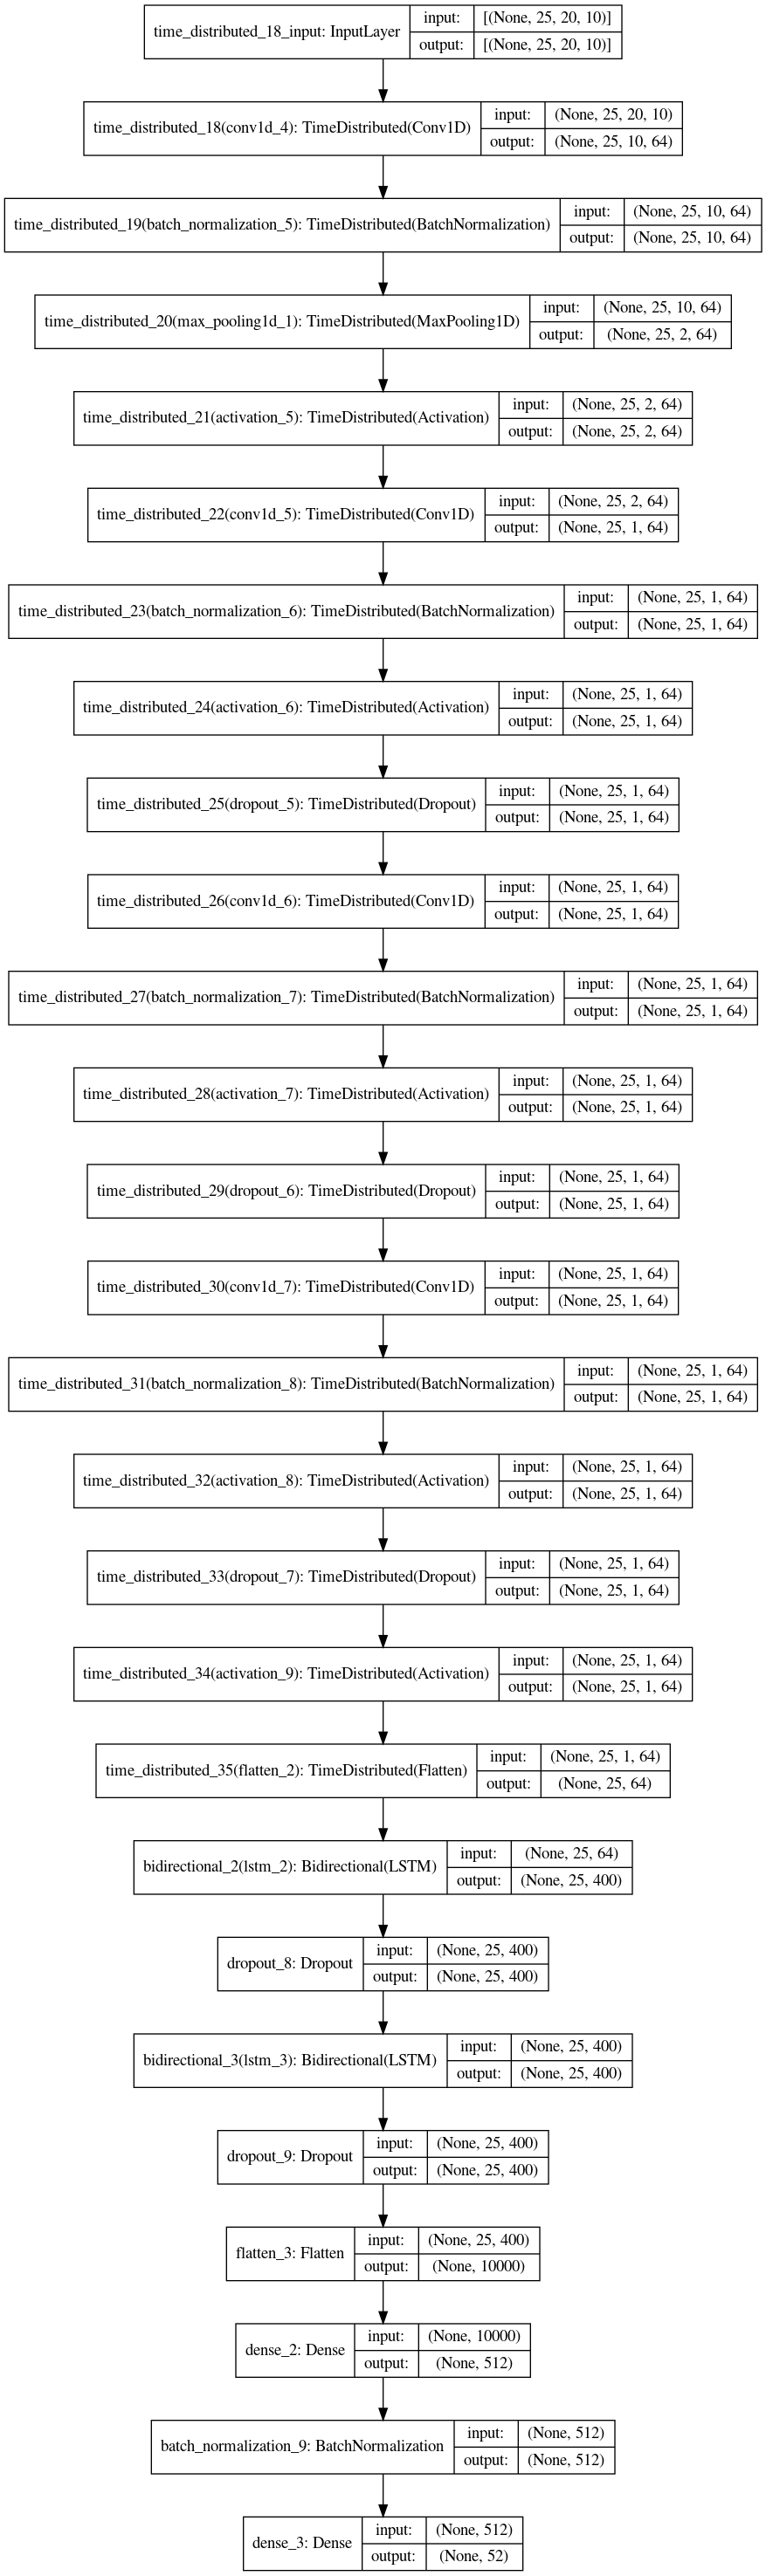

In [41]:
tf.keras.utils.plot_model(model, to_file='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/Model1.png',show_shapes=True,show_layer_names=True,dpi=96)

In [42]:
# adam=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# sgd=tfa.optimizers.SGDW(weight_decay=0.0001,learning_rate=0.1, momentum=0.9, nesterov=False, name='SGDW')
# sgd=tf.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False, name='SGD')
#     tf.keras.utils.plot_model(model, to_file='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/olsson/CNN20X10/Model1.png',show_shapes=True,show_layer_names=True,dpi=96)
csv_logger = CSVLogger('/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/CNN_nina_20X10.csv', append=True, separator=';')
history = model.fit(x_train, y_train_hot, epochs=epochs, batch_size=batch_size, callbacks=[csv_logger,checkpoint_callback,lrate,early],validation_data=(x_test, y_test_hot), verbose=1)
best_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
print('epoch_number',best_index+1)

Epoch 1/200
308/308 [==============================] - 24s 49ms/step - loss: 4.3615 - accuracy: 0.0786 - val_loss: 3.2299 - val_accuracy: 0.2239

Epoch 00001: val_accuracy improved from -inf to 0.22394, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/checkpoint.hdf5
Epoch 2/200
308/308 [==============================] - 7s 23ms/step - loss: 3.4321 - accuracy: 0.1803 - val_loss: 2.8367 - val_accuracy: 0.3054

Epoch 00002: val_accuracy improved from 0.22394 to 0.30539, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/checkpoint.hdf5
Epoch 3/200
308/308 [==============================] - 7s 24ms/step - loss: 3.0857 - accuracy: 0.2405 - val_loss: 2.5635 - val_accuracy: 0.3640

Epoch 00003: val_accuracy improved from 0.30539 to 0.36405, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/checkpoint.hdf5
Epoch 4/200
308/308 [==============================] - 7s 23ms/step - loss: 2.8241 -

308/308 [==============================] - 7s 23ms/step - loss: 0.9258 - accuracy: 0.7673 - val_loss: 0.8697 - val_accuracy: 0.7953

Epoch 00028: val_accuracy improved from 0.78152 to 0.79530, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/checkpoint.hdf5
Epoch 29/200
308/308 [==============================] - 7s 23ms/step - loss: 0.9078 - accuracy: 0.7795 - val_loss: 0.8240 - val_accuracy: 0.8055

Epoch 00029: val_accuracy improved from 0.79530 to 0.80551, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/checkpoint.hdf5
Epoch 30/200
308/308 [==============================] - 7s 24ms/step - loss: 0.8295 - accuracy: 0.8043 - val_loss: 0.8027 - val_accuracy: 0.8081

Epoch 00030: val_accuracy improved from 0.80551 to 0.80812, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/checkpoint.hdf5
Epoch 31/200
308/308 [==============================] - 7s 24ms/step - loss: 0.8326 - accura

308/308 [==============================] - 7s 24ms/step - loss: 0.2841 - accuracy: 0.9738 - val_loss: 0.5518 - val_accuracy: 0.8882

Epoch 00059: val_accuracy did not improve from 0.89100
Epoch 60/200
308/308 [==============================] - 7s 24ms/step - loss: 0.2499 - accuracy: 0.9813 - val_loss: 0.5569 - val_accuracy: 0.8910

Epoch 00060: val_accuracy did not improve from 0.89100
Epoch 61/200
308/308 [==============================] - 7s 24ms/step - loss: 0.2528 - accuracy: 0.9788 - val_loss: 0.5548 - val_accuracy: 0.8855

Epoch 00061: val_accuracy did not improve from 0.89100
Epoch 62/200
308/308 [==============================] - 7s 24ms/step - loss: 0.2450 - accuracy: 0.9823 - val_loss: 0.5566 - val_accuracy: 0.8870

Epoch 00062: val_accuracy did not improve from 0.89100
Epoch 63/200
308/308 [==============================] - 8s 25ms/step - loss: 0.2571 - accuracy: 0.9781 - val_loss: 0.5414 - val_accuracy: 0.8936

Epoch 00063: val_accuracy improved from 0.89100 to 0.89361, sav


Epoch 00094: val_accuracy did not improve from 0.90857
Epoch 95/200
308/308 [==============================] - 7s 24ms/step - loss: 0.1802 - accuracy: 0.9982 - val_loss: 0.4944 - val_accuracy: 0.9057

Epoch 00095: val_accuracy did not improve from 0.90857
Epoch 96/200
308/308 [==============================] - 7s 24ms/step - loss: 0.1832 - accuracy: 0.9966 - val_loss: 0.4963 - val_accuracy: 0.9014

Epoch 00096: val_accuracy did not improve from 0.90857
Epoch 97/200
308/308 [==============================] - 7s 24ms/step - loss: 0.1800 - accuracy: 0.9977 - val_loss: 0.4941 - val_accuracy: 0.9050

Epoch 00097: val_accuracy did not improve from 0.90857
Epoch 98/200
308/308 [==============================] - 7s 24ms/step - loss: 0.1805 - accuracy: 0.9972 - val_loss: 0.4968 - val_accuracy: 0.9019

Epoch 00098: val_accuracy did not improve from 0.90857
Epoch 99/200
308/308 [==============================] - 7s 24ms/step - loss: 0.1810 - accuracy: 0.9961 - val_loss: 0.4886 - val_accuracy: 0.

308/308 [==============================] - 7s 24ms/step - loss: 0.1700 - accuracy: 0.9984 - val_loss: 0.4859 - val_accuracy: 0.9060

Epoch 00134: val_accuracy did not improve from 0.91095
Epoch 135/200
308/308 [==============================] - 7s 24ms/step - loss: 0.1704 - accuracy: 0.9983 - val_loss: 0.4896 - val_accuracy: 0.9079

Epoch 00135: val_accuracy did not improve from 0.91095
Epoch 136/200
308/308 [==============================] - 7s 24ms/step - loss: 0.1724 - accuracy: 0.9974 - val_loss: 0.4810 - val_accuracy: 0.9114

Epoch 00136: val_accuracy improved from 0.91095 to 0.91142, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/checkpoint.hdf5
Epoch 137/200
308/308 [==============================] - 7s 24ms/step - loss: 0.1689 - accuracy: 0.9988 - val_loss: 0.4865 - val_accuracy: 0.9102

Epoch 00137: val_accuracy did not improve from 0.91142
Epoch 138/200
308/308 [==============================] - 7s 24ms/step - loss: 0.1699 - accuracy: 0.9

308/308 [==============================] - 7s 24ms/step - loss: 0.1686 - accuracy: 0.9982 - val_loss: 0.4777 - val_accuracy: 0.9083

Epoch 00174: val_accuracy did not improve from 0.91142
Epoch 175/200
308/308 [==============================] - 7s 24ms/step - loss: 0.1668 - accuracy: 0.9988 - val_loss: 0.4776 - val_accuracy: 0.9095

Epoch 00175: val_accuracy did not improve from 0.91142
Epoch 176/200
308/308 [==============================] - 8s 24ms/step - loss: 0.1674 - accuracy: 0.9986 - val_loss: 0.4789 - val_accuracy: 0.9140

Epoch 00176: val_accuracy improved from 0.91142 to 0.91403, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/checkpoint.hdf5
Epoch 177/200
308/308 [==============================] - 7s 24ms/step - loss: 0.1687 - accuracy: 0.9972 - val_loss: 0.4834 - val_accuracy: 0.9067

Epoch 00177: val_accuracy did not improve from 0.91403
Epoch 178/200
308/308 [==============================] - 8s 25ms/step - loss: 0.1676 - accuracy: 0.9

In [43]:
import datetime

In [44]:
print('train accuracy and validation accuracy', history.history['accuracy'][best_index], history.history['val_accuracy'][best_index])
model.load_weights(checkpoint_filepath) 
print(datetime.datetime.now())
_, testaccuracy = model.evaluate(x_test, y_test_hot, batch_size=batch_size, verbose=1)
print(datetime.datetime.now())
print('test_accuracy',testaccuracy)
# test_acc.append(testaccuracy)

train accuracy and validation accuracy 0.998677134513855 0.9140346646308899
2021-11-13 11:25:02.478178
132/132 [==============================] - 1s 10ms/step - loss: 0.4789 - accuracy: 0.9140
2021-11-13 11:25:03.850660
test_accuracy 0.9140346646308899


In [45]:
model.save('/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/CNN_LSTM_nina_5X97')

INFO:tensorflow:Assets written to: /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/CNN_LSTM_nina_5X97/assets


INFO:tensorflow:Assets written to: /media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/CNN_LSTM_nina_5X97/assets


history loss
history accuracy
history val_loss
history val_accuracy
history lr


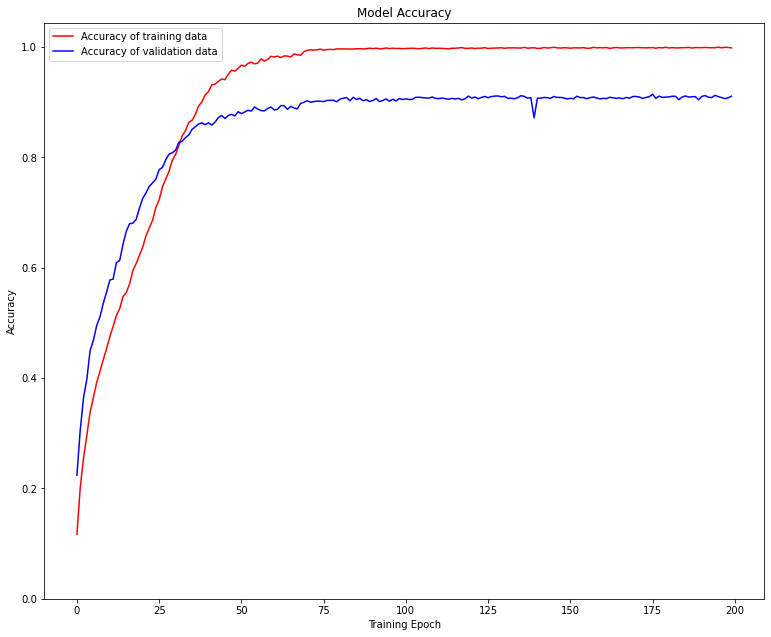

In [46]:
for i in history.history:
    print("history",i)
# facecolor='black'
DB1a=plt.figure(figsize=(10, 8),edgecolor='black')
# ax=figDB4.add_axes(("left", "bottom", "width", "height"))
ax= DB1a.add_axes((1,1,1,1))
ax.spines["top"].set_position(("outward", 0))
ax.spines["bottom"].set_position(("data", 0))
ax.spines["left"].set_position(("axes", 0))
ax.spines["right"].set_position(("outward", 0))

ax.spines["top"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["bottom"].set_color("black")

# ax.spines["left"].set_bounds(-.5, .5)
# ax.spines["right"].set_linestyle("--")
# ax.spines["bottom"].set_linewidth(6)
# ax.spines["bottom"].set_capstyle("round")

# plt2.rcParams['figure.facecolor'] = 'white'
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')

# plt2.ylim(0)
# plt2.rcParams['figure.facecolor'] = 'white'

# ax = fig.add_axes((left, bottom, width, height))
ax.set(facecolor="white")
# ax.patch.set_alpha(1.0)
plt.ylim(0)
plt.legend()
plt.show()

history loss
history accuracy
history val_loss
history val_accuracy
history lr


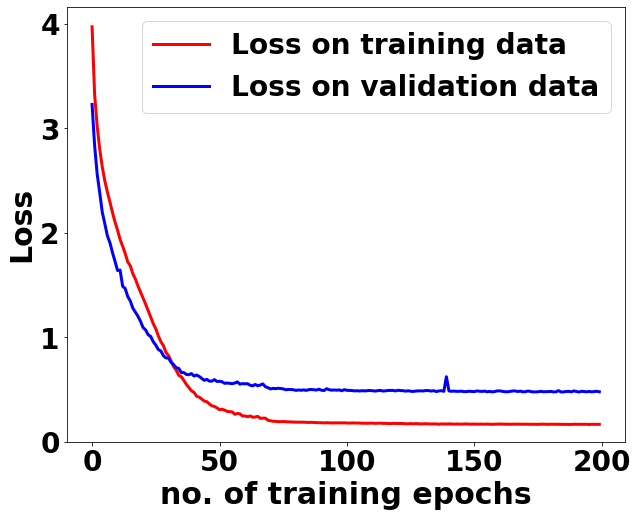

In [47]:
for i in history.history:
    print("history",i)
# facecolor='black'
# ax= figDB1.add_axes((1,1,1,1))
# ax.spines["top"].set_position(("outward", 0))
# ax.spines["bottom"].set_position(("data", 0))
# ax.spines["left"].set_position(("axes", 0))
# ax.spines["right"].set_position(("outward", 0))

# ax.spines["top"].set_color("black")
# ax.spines["left"].set_color("black")
# ax.spines["right"].set_color("black")
# ax.spines["bottom"].set_color("black") 

figDB1=plt.figure(figsize=(10, 8),edgecolor='black')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 28}

plt.rc('font', **font)

# SMALL_SIZE = 12
# MEDIUM_SIZE = 14
# BIGGER_SIZE = 18

# figBPR.suptitle('test title', fontsize=20)
#plt.rc('xlabel', fontsize=14, weight = 'bold')
#plt.rc('ylabel', fontsize=14, weight = 'bold')

# plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
# plt.rc('axes', labelsize=MEDIUM_SIZE )     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE, weight = 'bold')    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE )  # fontsize of the figure title

# ax=figDB1.add_axes(("left", "bottom", "width", "height"))
# ax= figDB1.add_axes((1,1,1,1))
# ax.spines["top"].set_position(("outward", 0))
# ax.spines["bottom"].set_position(("data", 0))
# ax.spines["left"].set_position(("axes", 0))
# ax.spines["right"].set_position(("outward", 0))

# ax.spines["top"].set_color("black")
# ax.spines["left"].set_color("black")
# ax.spines["right"].set_color("black")
# ax.spines["bottom"].set_color("black")

# ax.spines["left"].set_bounds(-.5, .5)
# ax.spines["right"].set_linestyle("--")
ax.spines["top"].set_linewidth(3)
ax.spines["top"].set_linestyle("-")
ax.spines["bottom"].set_linewidth(3)
ax.spines["bottom"].set_linestyle("-")
ax.spines["left"].set_linewidth(3)
ax.spines["left"].set_linestyle("-")
ax.spines["right"].set_linewidth(3)
ax.spines["right"].set_linestyle("-")
# ax.spines["bottom"].set_capstyle("round")

# plt2.rcParams['figure.facecolor'] = 'white'
plt.plot(history.history['loss'], 'r-', linewidth=3, label='Loss on training data')
plt.plot(history.history['val_loss'], 'b-', linewidth=3, label='Loss on validation data')
# plt.title('Loss curve for NinaPro DB1',fontsize=18, weight = 'bold')

plt.ylabel('Loss',fontsize=30, weight = 'bold')
plt.xlabel('no. of training epochs',fontsize=30, weight = 'bold')
# plt2.ylim(0)
# plt2.rcParams['figure.facecolor'] = 'white'

# ax = fig.add_axes((left, bottom, width, height))
ax.set(facecolor="white")
# ax.patch.set_alpha(1.0)
plt.ylim(0)
plt.legend()
plt.show()

In [48]:
figDB1.savefig('/media/naveen/nav/plots/NinaPro_DB1_25X20.eps',transparent=False)
# figDB1.savefig('/media/naveen/nav/plots/NinaPro_DB1_25X20.pdf',transparent=False)

In [49]:
model.load_weights(checkpoint_filepath) 
_, testaccuracy = model.evaluate(x_test, y_test_hot, batch_size=batch_size, verbose=1)
print('test_accuracy',testaccuracy)

132/132 [==============================] - 1s 9ms/step - loss: 0.4789 - accuracy: 0.9140
test_accuracy 0.9140346646308899


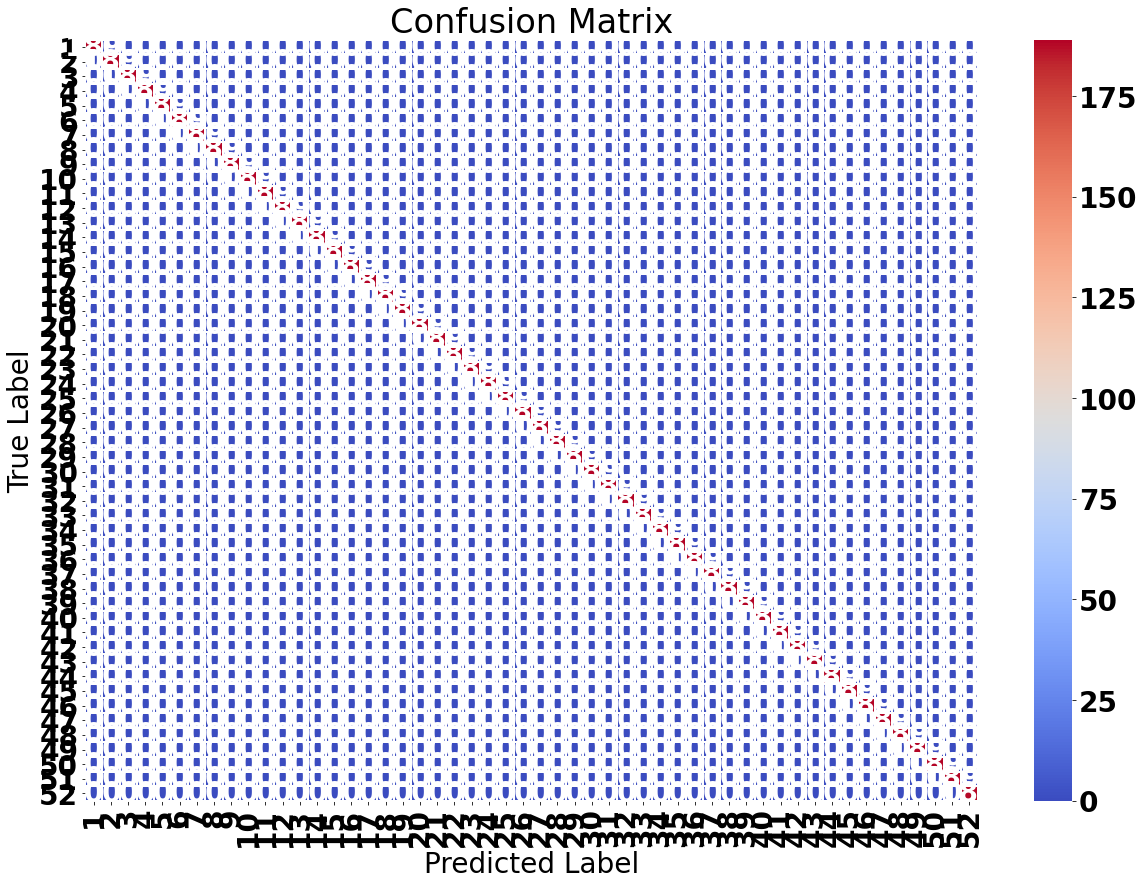

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00       189
           2       1.00      1.00      1.00       189
           3       1.00      1.00      1.00       189
           4       1.00      1.00      1.00       189
           5       1.00      1.00      1.00       189
           6       1.00      1.00      1.00       189
           7       1.00      1.00      1.00       189
           8       1.00      1.00      1.00       189
           9       1.00      1.00      1.00       189
          10       1.00      1.00      1.00       189
          11       1.00      1.00      1.00       189
          12       1.00      1.00      1.00       189
          13       1.00      1.00      1.00       189
          14       1.00      1.00      1.00       189
          15       1.00      1.00      1.00       189
          16       1.00      1.00      1.00       189
          17       1.00    

In [50]:
y_pred_train = model.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
#max_y_train = np.argmax(y_train, axis=1)
show_confusion_matrix(y_train, max_y_pred_train)
print(classification_report(y_train, max_y_pred_train))

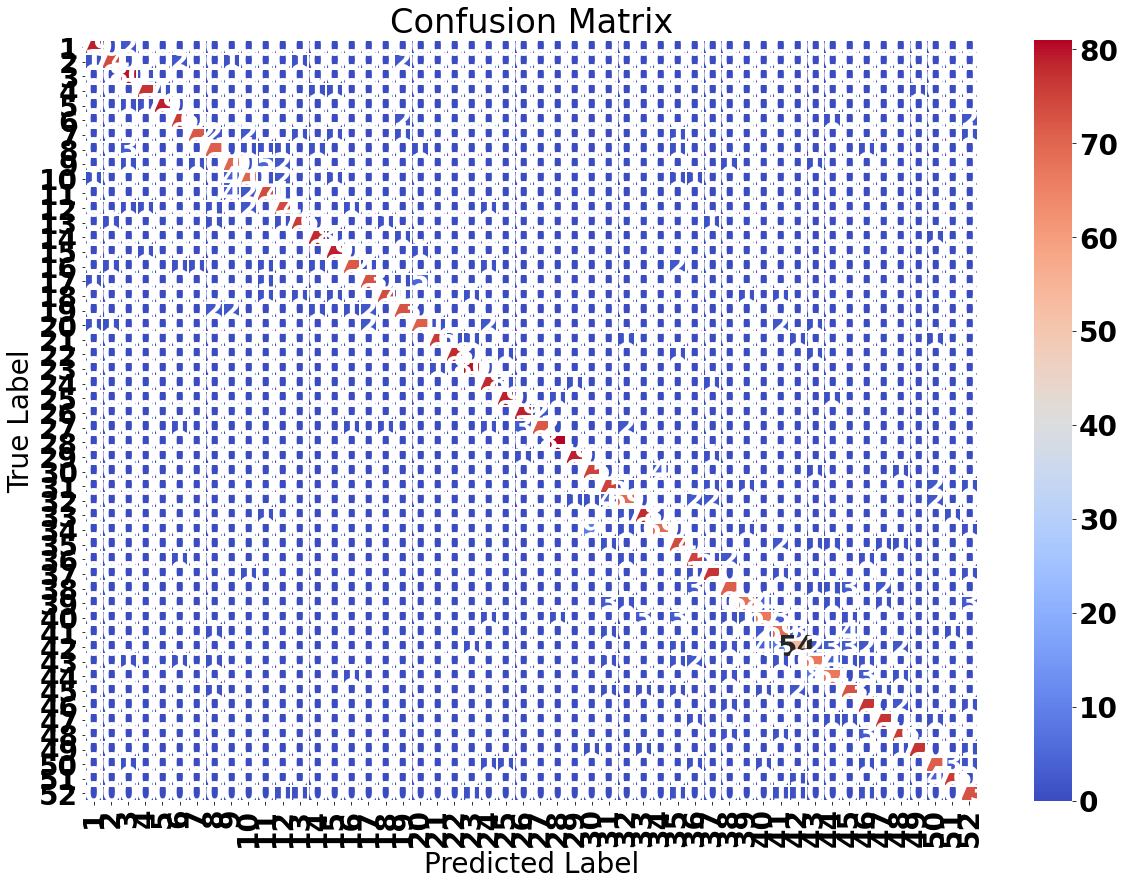

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        81
           1       0.96      0.91      0.94        81
           2       0.89      0.99      0.94        81
           3       0.95      0.95      0.95        81
           4       0.99      0.98      0.98        81
           5       0.93      0.94      0.93        81
           6       0.97      0.89      0.93        81
           7       0.89      0.88      0.88        81
           8       0.86      0.86      0.86        81
           9       0.90      0.86      0.88        81
          10       0.87      0.91      0.89        81
          11       0.90      0.91      0.91        81
          12       0.95      0.94      0.94        81
          13       0.95      0.96      0.96        81
          14       0.94      0.98      0.96        81
          15       0.95      0.89      0.92        81
          16       0.94      0.90      0.92        81
          17       0.97    

In [51]:
fopen = open("/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/naveen_DB1_test.csv","a")
y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)
for i in range(0, len(max_y_pred_test)):
    fopen.writelines(str(max_y_test[i])+","+str(max_y_pred_test[i])+"\n")
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))
fopen.close()